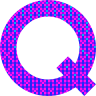
# Finding non-linear interactions in data
In this notebook, I will *not* go through the usual hoops of exploratory data analysis. That is indeed valuable, but has already been done quite thoroughly in other people's work.

Instead I will demonstrate a method to look for less obvious relationships in the data that can cast completely new light on it.

# Use a Community QLattice
The QLattice is a supervised machine learning tool for symbolic regression developed by [Abzu](https://www.abzu.ai) . It is inspired by Richard Feynman's path integral formulation. That's why the python module to use it is called *Feyn*, and the *Q* in QLattice is for Quantum.

Abzu provides free QLattices for non-commercial use to anyone. These free community QLattices gets allocated for us automatically when we use Feyn without an active subscription, which is what we do in this notebook. Read more about how it works here: https://docs.abzu.ai/docs/guides/getting_started/community.html

# Relationships in the data
One use of symbolic regression in data analysis is to get a sense of how the individual features relate to each other and to the target. This kind of insight can supplement more conventional data analysis by higlighing non-linear relationships and interactive relationships. In this notwbook we will mot concern ourselves with the predicting water potability, but rather with understanding the relationships between the different features.

# Install the feyn module
The feyn Python module is not installed on Kaggle by default so we have to pip install it first. 
__Note__: the pip install will fail unless you enable *Internet* in the *settings* to the right --->


In [ ]:
!pip install feyn

# Python imports
In this notebook we will use only two python modules: the `feyn` module to access the QLattice, and the `pandas` module to access the data

In [ ]:
import pandas as pd
import feyn

# Allocate a QLattice
The actual QLattice is a quantum simulator that runs on Abzu's hardware, but we can allocate on to use for our analysis with a single line of code. Hopefully the following line will get us one.

In [ ]:
ql = feyn.connect_qlattice()

# Resetting and reproducability
The QLattice has the potential to store learnings between sessions to enable transfer of learning and federated learning. This is not possible with Community QLattices, since a new one gets allocated whenever we run the notebook, so it is not strictly necessary to call the reset function on our new QLattice. 

But the reset function also allows us to provide a random seed, which will ensure that we get the same results every time we run this notebook

In [ ]:
ql.reset(random_seed=42)

# Data
Now we are read in the data and have a quick look at it:

In [ ]:
df = pd.read_csv("/kaggle/input/water-potability/water_potability.csv")
df

# Missing data
Let us first look if we have missing data 

In [ ]:
df.isna().sum()

We note that out of the 3276 obesrvations in the data set, a few hundred have missing data. For now we just drop those, but we can return to the missing data and how to use the QLattice to impute it a bit later in the notebook


In [ ]:
df_complete = df.dropna()


# Relationship of features to the target
The target value in the dataset is `Potability`. As a first step we will ask the QLattice to find which of the features relates the strongest to the target.

## Mathematical expressions and the`query_string`
We do this by using the "query" functionality in the QLattice. Using QLattice queries we can do things such as find the feature that relates strongest to the target allowing for a unary transformation. A unary transformation is a single function, such as $y=log(x)$ which makes $x$ correlate better with the target. In traditional correlation analysis, you may miss that $x$ is related to $y$ through some non-linear transfomation.

We will use the query string `func(?)` to the QLattice. `func` is a wildcard that will match any unary function, and `_` is a wildcard that will match any expression. The `[0]` tells the QLattice that the `_` expression must be zero long, which means that it must be an *input feature*.

Let's try:

In [ ]:
models = ql.auto_run(df_complete, output_name="Potability", query_string="func(_[0])")

# Sulfate is the strongest relationship
We see that Sulfate is strongly related to Potability, but squared, rather than linearly. We can also examine the actual mathematical expression:

In [ ]:
models[0].sympify(2) # Show the relationship as an expression with two significant digits in each parameter

# Interaction parameters 
Next step is to look for interaction parameters between Sulfate and any of the other features. Traditional linear analysis will not reveal interaction terms, but this is quite easy to do with the QLattice.

This time, we ask for any function of two parameters, where one must be Sulfate, and the other can be any feature directly. 

We will use the query string: `func('Sulfate', ?)` to do this. In this string `func` is now a function of two parameters. The first parameter must explicitly be`Sulfate`, while the second parameter can `?` meaning any feature. Note the differnece between the wildcard `_` which matches any expression, and `?` which matches a specific feature, thus `_[0]` actually means exactly the same as `?`. I intentionally used both in this notebook to show how they are used.

In [ ]:
models = ql.auto_run(df_complete, output_name="Potability", query_string="func('Sulfate', ?)")

# Sulfate multiplied with ph

Sulfate seems to interact with ph. The fact that the interaction is a multiply operation is significant in that the two features in some way interact with each other. Let's again look at the actual math:

In [ ]:
models[0].sympify(2) # Show the relationship as an expression with two significant digits in each parameter

# The strength of the relation?
Now we know the strongest non-linear and interactive relationship with the target, lets see how strong it actually is:

In [ ]:
models[0].plot(df_complete, corr_func="pearson")

# Interaction
Notice that the pearson correlation of ph and Sulfate are not very strong (the small numbers above the two leftmost nodes). But once they get multilplied together we get a much stronger pearson correlation (the small number above the "mulitply" node). Note that a negative pearson correlation is still a correlation.
 
# Partial plots
Since the relationships found by the QLattice are really mathematical analytical expressions, we can plot them in various ways. A quite usefull plot is the [partial plot](https://docs.abzu.ai/docs/guides/plotting/partial_plot.html) which allows us to fix certain input values and plot the function with respect to the other one.

Here, we will plot the function with respect to ph. The plotting engine will choose representative values for the other intput, in this case Sulfate, so we will end up with three different lines

In [ ]:
models[0].plot_partial(df_complete, by="ph")

The blue line is the predicted potability as ph increases at a Sulfate level if 307, which is the lowest quartile. We see that probaility of potability increases with ph.

In contrast, the cyan line shows that the probability of potability *decreases* with ph if the Sulfate level is 359, which is the highest quartile. Thus, high levels of Sulfate effectivly inverses the effect of ph acidity.

This is the kind of relation that ordinary correlation analysis could never pick up, and which a linear model could not incorperate. 

# What does it mean?
I can offer guesses to what the reason is for this interaction, but I'm by no means an expert in water potability. Maybe a there are different kinds of sulfate, which leads to different acidity effects, and some of these sulfates are toxic whulo others are not? __Perhaps a reader can offer a better explanation in the comments?__

# Other relationships and scientific thinking
We could continue exploring relationships between the features with crafted query strings, and I can spend hours doing so on a new dataset and learn a lot about how things fit together. This is in fact what scientists typically use the QLattice for, and some of these relationships discovered in this way can become real scientific knowledge.

But in this notebook, I'll instead zoom in on a specific use of this kind of analysis, namely imputation of missing data.

# Imputation revisited
Note that the two features found above, Sulfate and ph, happen to also be the two features in the entire dataset that has *the most* missing values. This would indicate that we would gain a lot if we were able to impute these values.

Let us see if that seems to be possible. We can do this by asking the QLattice to find a model that will calculate either from the other features.

# Imputing Sulfate. 
Now we will no longer be looking for relationship with Potability, but instead with Sulfate. And we need to remember to disallow Potability as a feature, because we ultimately would like to predict this. We will also disallow ph and Trihalomethanes as features because these themselves have missing values, which perhaps overlap with the missing values for Sulfate.

This time we will not use a query string, but just ask the QLattice for the best model to predict Sulfate. We will restrict the model by Bayesian Information Criterion, which will lead to simpler model with more statistical foundation. Read more about that here: https://docs.abzu.ai/docs/guides/primitives/fit_models.html

In [ ]:
models = ql.auto_run(df_complete.drop(["Potability", "ph","Trihalomethanes"], axis=1), output_name="Sulfate", criterion="bic")

# Does the imputation function work?
We have found that there is at least some relationship between Sulfate and the Hardness miltiplied with Solids. But how strong is it? This time let's look at the $R^2$ value

In [ ]:
models[0].r2_score(df_complete)

Only about 0.04 $R^2$. Not impressive, but perhaps better that naive mean imputation. Let's take note of the math expression.

In [ ]:
models[0].sympify(2)

# A linear adjustment
We see that the model for Sulfate is linear with an intercept of 380, corrected by small negative adjustments for hardness and solids. This is probably a sligtly better approach to imputation of Sulfate than mere mean imputation. We will try that in another future notebook where we will be fitting a predictive model using the QLattice.


# Imputing ph. 
Now we will turn our attention to imputing ph. Again, we disallow Potability as a feature, because we ultimately would like to predict this. We will also disallow Sulfate and Trihalomethanes as features because these themselves have missing values, which perhaps overlap with the missing values for ph.

We again restrict the model by Bayesian Information Criterion.

In [ ]:
models = ql.auto_run(df_complete.drop(["Potability", "Sulfate","Trihalomethanes"], axis=1), output_name="ph", criterion="bic")

# A slightly more complicated model
This model incorporates several components. The Hardness is exponetially transformed and then combined linearly with Solids. Finally the entire result is squared. Let's se how it performs

In [ ]:
models[0].r2_score(df_complete)

Hmm, not really impressive. Check the math

In [ ]:
models[0].sympify(2)

The constant of 6.7 seams to be the main prediction, combined with and adjustment for Hardness and Solids. This could be an interesting example for a partial plot. Lets see

In [ ]:
models[0].plot_partial(df_complete, by="Hardness")

# Overfitting
These curves looks overfitted to me. The Left side curls up to capture what is probably outliers. I would not use this function to impute with, but instead force the QLattice to give me even simpler models. It really looks to me as if there is a linear function in action here. Lets use a query string to force it to find a linear model of two parameters

In [ ]:
models = ql.auto_run(df_complete.drop(["Potability", "Sulfate","Trihalomethanes"], axis=1), output_name="ph", query_string="?+?")

Let's do a partial plot of this model as well

In [ ]:
models[0].plot_partial(df_complete, by="Hardness")

I would prefer that even if it fits less well. But it is a matter of intution, and to be entirely rigid we should test these models on a test set, just as if we were actually doing a prediction model. We'll leave that exercise to a future notebook

# Conclusion
In this notebook we have seen how to use the QLattice to search through huge numbers of possible mathematical expressions to find the ones that fits the data best. This can be used for predition modeling, such as for example in this paper: 
[Symbolic regression outperforms other models for small data sets](https://arxiv.org/abs/2103.15147)

Or it can be used for inducing scientific knowledge, such as for example in this work: [AI and nucleic acid based medicine: can symbolic regression unite them?](https://medium.com/abzuai/the-qlattice-applied-to-antisense-therapy-ccccd77ce28).

Finally, it can be used for learning and exploring non-linear interactions if any data set such as we have done in this notebook. I hope you found it interesting and that is has encouraged you to try the QLattice out for yourself.